Based on:
- https://github.com/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_PyTorch_Lightning.ipynb
- https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/11-vision-transformer.html

In [19]:
# logging
import wandb
from pytorch_lightning.loggers import WandbLogger

# use HuggingFace to get data and pre-trained models
from datasets import load_dataset
from transformers import ViTImageProcessor, ViTForImageClassification

# model training
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint

# plotting
import matplotlib.pyplot as plt

## 1: Load CIFAR10 data

From HuggingFace

In [2]:
# load cifar10 - the data is already split into a train and test set
# (only load a small portion of each) 
train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])

# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [3]:
# each data point is a dictionary with image and label
train_ds[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

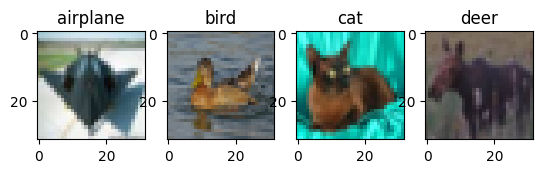

In [4]:
# labels are provided as integer values
# here we map those to the actual label names
label_names = {id:label for id, label in enumerate(train_ds.features['label'].names)}

fig, ax = plt.subplots(1, 4)
for i in range(4):  
    ax[i].imshow(train_ds[i]['img'])
    ax[i].set_title(label_names[train_ds[i]['label']])

## 2: Preprocess data

In [5]:
# the ViT processor corresponds to the model we will use 
#   - it is pointed to the same checkpoint
# for example, this creates patch sizes of 16x16
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]

image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]

In [28]:
# normalize all data to get better training performance
# also use augmentation during training
train_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(image_mean, image_std)
    ]
)

# make sure the val/test data is residez correctly to what the model expects
# but otherwise don't augment
test_transforms = transforms.Compose(
    [
        transforms.Resize(size),
        transforms.CenterCrop(size),        
        transforms.ToTensor(),
        transforms.Normalize(image_mean, image_std)
    ]
)

def apply_train_transforms(examples):
    examples['pixel_values'] = [train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def apply_test_transforms(examples):
    examples['pixel_values'] = [test_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

# dataset.set_transform
# https://huggingface.co/docs/datasets/v1.11.0/package_reference/main_classes.html?highlight=set_format#datasets.Dataset.set_transform
train_ds.set_transform(apply_train_transforms)
val_ds.set_transform(apply_test_transforms)
test_ds.set_transform(apply_test_transforms)

## 3: Create DataLoaders

Wrapper for something that can iterate over

In [30]:
batch_size = 2

def collate_fn(examples):
    # created `pixel_values` as part of data transforms above
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_loader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)

In [31]:

# each batch will have size 2 and is a dictionary of pixel_values and labels
batch = next(iter(train_loader))

print(batch.keys())

for k,v in batch.items():
    print(k, v.shape)

dict_keys(['pixel_values', 'labels'])
pixel_values torch.Size([2, 3, 224, 224])
labels torch.Size([2])


## 4: Specify model

Here we define a LightningModule, which is very similar to a regular nn.Module, but with some additional functionalities. It breaks down training into a number of core methods:
- forward
- training_step
- validation_step
- test_step
- predict_step
- configure_optimizers


The model we use is: https://huggingface.co/google/vit-base-patch16-224-in21k
- "if you have a dataset of labeled images for instance, you can train a standard classifier by placing a linear layer on top of the pre-trained encoder. One typically places a linear layer on top of the [CLS] token, as the last hidden state of this token can be seen as a representation of an entire image."
- most of the model weights are downloaded from the checkpoint except for the classification parameters ('classifier.bias', 'classifier.weight') - it is expected that one fine-tunes the model for a specific classification task


In [32]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}

In [33]:
class ViTLightningModule(pl.LightningModule):
    def __init__(self, num_labels=10, lr=3e-4):
        super(ViTLightningModule, self).__init__()
        # this saves any arguments passed to the init method in self.hparams
        # in this case that's only `num_labels` and `lr`
        self.save_hyperparameters()
        print("hparams", self.hparams)
        # https://huggingface.co/docs/transformers/v4.47.1/en/model_doc/vit#transformers.ViTConfig
        # https://huggingface.co/google/vit-base-patch16-224-in21k/blob/main/config.json
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                              num_labels=num_labels,
                                                              id2label=id2label,
                                                              label2id=label2id)

    def forward(self, pixel_values):
        # inside vit forward method the image is transformed into patches and then
        # the CLS token and positional embeddings are concatenated with the patches
        # this is passed through the transformer and then the transformed class token is 
        # passed through a linear layer and that is what is returned here 
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits
        
    def _step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        # this calls the forward method
        logits = self(pixel_values)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)
        # logits are usually of shape - (batch size, num classes)
        # here return index of the max value along the last dimension (class)
        # shape of returned tensor is (batch_size,)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy
      
    def training_step(self, batch, batch_idx):
    # this does the expected stuff under the hood like:
    # ```
    # torch.set_grad_enabled(True)
    # for batch_idx, batch in enumerate(train_dataloader):
    #     loss = training_step(batch, batch_idx)
    #     # clear gradients
    #     optimizer.zero_grad()
    #     # backward
    #     loss.backward()
    #     # update parameters
    #     optimizer.step()
    #```
        loss, accuracy = self._step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self._step(batch, batch_idx)     
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, _ = self._step(batch, batch_idx)     

        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        # could skip the LR scheduler for this example
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return val_loader

    def test_dataloader(self):
        return test_loader

## 5. Train

In [37]:
wandb_logger = WandbLogger(project="Test ViT", log_model=True)

In [38]:
model = ViTLightningModule()
trainer = Trainer(accelerator="mps", 
                  callbacks=[EarlyStopping(monitor='validation_loss'), 
                            ModelCheckpoint(save_weights_only=True, mode="max", monitor="validation_accuracy"),
                            LearningRateMonitor("epoch")],
                  logger=wandb_logger,
                  # if don't actually have the time to run this as long as need to and want 
                  # to see some results can set max_epochs here...
                  max_epochs=2)
trainer.fit(model)

hparams "lr":         0.0003
"num_labels": 10


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: r-jersakova (radka-j). Use `wandb login --relogin` to force relogin



  | Name | Type                      | Params | Mode
----------------------------------------------------------
0 | vit  | ViTForImageClassification | 85.8 M | eval
----------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.225   Total estimated model params size (MB)
0         Modules in train mode
226       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/rjersakova/Documents/Projects/LDL/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/Users/rjersakova/Documents/Projects/LDL/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
0.02s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


TODO: fix below

In [43]:
trainer.test(model, test_loader, verbose=False)

Testing: |          | 0/? [00:00<?, ?it/s]

[{}]